# Modelo para calcular edad de los clientes

La cadena de Good Seed ha solicitado desarrollar un modelo que permita identificar la mayoría de edad para los clientes que están comprando licor, esta herramienta servirá como apoyo para identificar a menores de edad según la imagen capturada por las cámaras en cada establecimiento. El modelo deberá identificar la edad de los clientes.

## Inicialización

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

### Cargamos las etiquetas

In [3]:
# Cargamos el archivo con las etiquetas y edad.
try:
    labels_df = pd.read_csv('/datasets/faces/labels.csv')
except:
    labels_df = pd.read_csv('labels.csv')

In [4]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels_df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


### Cargamos las imagenes

In [6]:
# Cargamos el las imagenes 

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory='/datasets/faces/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [7]:
features, target = next(train_gen_flow)

In [8]:
features.shape

(32, 224, 224, 3)

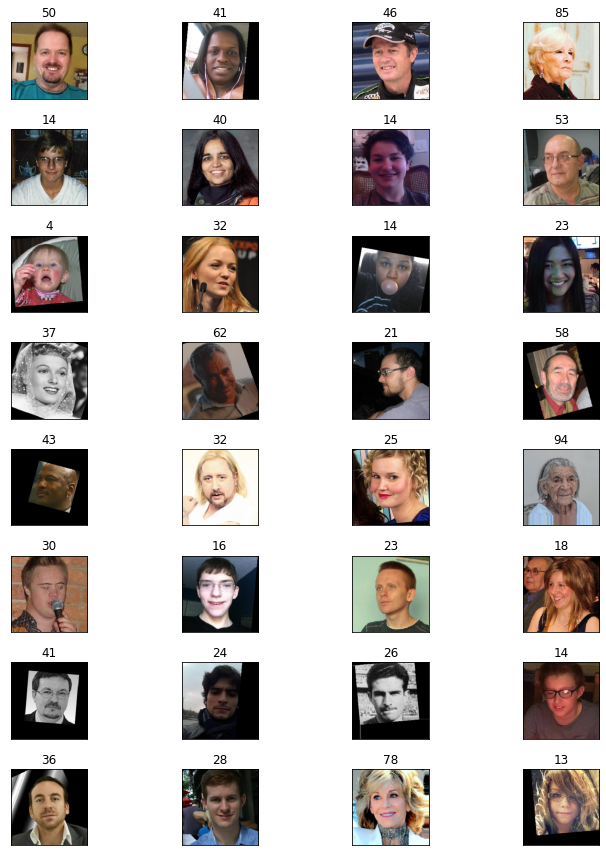

In [9]:
fig = plt.figure(figsize=(12,12))
for i in range(32):
    fig.add_subplot(8, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## EDA

In [10]:
# Visualizamos un resumen de las edades del conjunto de datos
labels_df['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


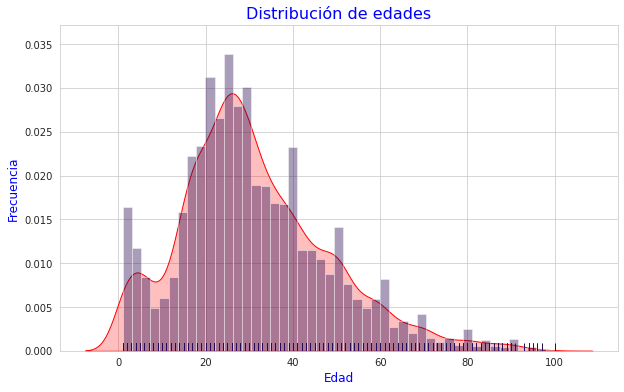

In [11]:
# Visualizamos la distribución de las edades
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set_palette('inferno')
sns.distplot(labels_df['real_age'], rug=True, kde_kws={'shade':True, 'color':'r'})
plt.xlabel('Edad', fontsize=12, color='b')
plt.ylabel('Frecuencia', fontsize=12, color='b')
plt.title('Distribución de edades', fontsize=16, color='b')
plt.show()

<AxesSubplot:>

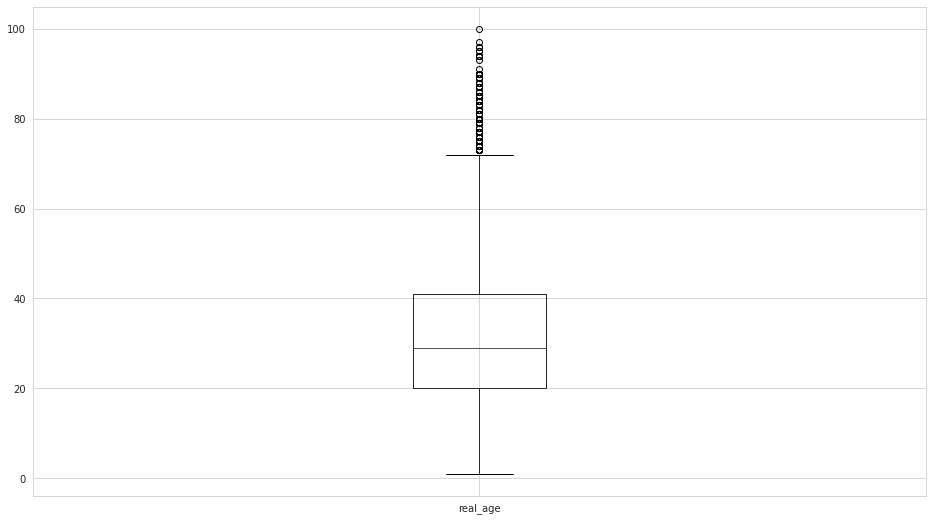

In [12]:
# Observamos los valores atípicos
labels_df.boxplot('real_age', figsize= (16,9))

In [13]:
# Obtenemos la cantidad de personas que son menores de edad.
under_age = labels_df[labels_df['real_age']<21].shape[0]
print(f'El {(under_age/labels_df.shape[0])*100:.2f} % del total de las personas son menores de edad.')

El 27.06 % del total de las personas son menores de edad.


### Conclusiones

**Conclusiones:**

- El conjunto de datos tiene una distribución normal sesgada a la derecha, que nos indica que la mayoría de personas se concentra en un rango de 20 a 40 años.

- Solo el 27% del total de las personas son menores de edad.

- Tenemos casos atípicos de mas de 75 años.

- En resumen el conjunto de datos es ideal para analizar su edad.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [15]:
# Definimos una función para cargar los datos de entrenamiento
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    
    train_gen_flow = train_datagen.flow_from_directory(
        path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='sparse',
        subset='training',
        seed=12345)

    return train_gen_flow

In [16]:
# Definimos una función para cargar los datos de prueba
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    
    test_gen_flow = train_datagen.flow_from_directory(
        path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='sparse',
        subset='validation',
        seed=12345)

    return test_gen_flow

In [17]:
# Definimos una función para crear el modelo
def create_model(input_shape):
    
    backbone = ResNet50(
    input_shape=input_shape, weights='imagenet', include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(12, activation='relu')) 
    model.add(Dense(24, activation='softmax')) 
    optimizer = Adam()
    model.compile(
        optimizer= optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['acc'],
    )
    
    

    return model

In [18]:
# Definimos una función para entrenar el modelo
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 
    
    model.fit(
        train_data,
        validation_data= test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
    )

    return model

## Script para ejecutarlo en la plataforma GPU

In [20]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = '''
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam


train_data = load_train
test_data = load_test

model = create_model(input_shape= (224,224,3))

model = train_model(model, train_data, test_data)
'''

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### El resultado

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param 

resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      

Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
None
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/15


2023-09-15 15:46:44.170362: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2023-09-15 15:46:44.401693: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

178/178 - 45s - loss: 10.7913 - mae: 10.7915 - val_loss: 12.8473 - val_mae: 12.8051
Epoch 2/15


178/178 - 37s - loss: 8.4043 - mae: 8.4051 - val_loss: 16.5335 - val_mae: 16.5213
Epoch 3/15


178/178 - 38s - loss: 7.7224 - mae: 7.7221 - val_loss: 13.8480 - val_mae: 13.8212
Epoch 4/15


178/178 - 37s - loss: 6.6421 - mae: 6.6419 - val_loss: 13.0202 - val_mae: 12.9860
Epoch 5/15


178/178 - 38s - loss: 6.1034 - mae: 6.1036 - val_loss: 10.0958 - val_mae: 9.9827
Epoch 6/15


178/178 - 38s - loss: 5.6198 - mae: 5.6199 - val_loss: 7.0887 - val_mae: 7.0779
Epoch 7/15


178/178 - 38s - loss: 5.1406 - mae: 5.1408 - val_loss: 8.9132 - val_mae: 8.8802
Epoch 8/15


178/178 - 37s - loss: 4.8185 - mae: 4.8187 - val_loss: 7.7269 - val_mae: 7.7264
Epoch 9/15


178/178 - 37s - loss: 4.4150 - mae: 4.4154 - val_loss: 7.2635 - val_mae: 7.2581
Epoch 10/15


178/178 - 38s - loss: 4.3342 - mae: 4.3346 - val_loss: 8.1293 - val_mae: 8.1497
Epoch 11/15


178/178 - 37s - loss: 3.8756 - mae: 3.8758 - val_loss: 7.4496 - val_mae: 7.4606
Epoch 12/15


178/178 - 37s - loss: 3.7278 - mae: 3.7281 - val_loss: 8.0039 - val_mae: 8.0224
Epoch 13/15


178/178 - 37s - loss: 3.5114 - mae: 3.5114 - val_loss: 7.7778 - val_mae: 7.7876
Epoch 14/15


178/178 - 37s - loss: 3.3171 - mae: 3.3172 - val_loss: 8.3936 - val_mae: 8.3975
Epoch 15/15


178/178 - 38s - loss: 3.1205 - mae: 3.1205 - val_loss: 6.9151 - val_mae: 6.9308
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 6.9151 - mae: 6.9308
Test MAE: 6.9308

## Conclusiones

**Conclusiones:**

El resultado de un MAE de 6.93 es bastante bueno ya que permite predecir la edad de una persona con mucha exactitud la cual puede servir como herramienta de apoyo para una tienda de venta de licores, pero en la práctica solo sería una herramienta de apoyo ya que la red analiza los contornos encontrados en las imagenes lo que sería los pliegues de las expresiones faciales, este quiere decir que depende de las condiciones de luz al momento de tomar la fotografía ya que de esto dependo que ciertas expresiones se marquen mas. Además hay que tomar en cuenta que el error absoluto medio es de 6.93, esto quiere decir que si una persona de 